In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from openfast_io.turbsim_file import TurbSimFile
from openfast_io.turbsim_util import TurbsimReader, TurbsimWriter


In [2]:

hurrCat = 'CAT2'
numSeeds = 36
writeFolder = '../turb_sim/TurbSimGenFiles'

baseInputFolder = '../turb_sim'

# change this to your path to TurbSim executable
TurbSimExe = '../../i_devFiles/openfast/build/modules/turbsim/turbsim'

In [3]:
# functions
def turbSimSeedGen(baseInputFile, runDir, nSeeds=36, seed=0):
    # Reading turbsim input file
    ts_reader = TurbsimReader()
    ts_reader.read_input_file(baseInputFile)

    # if write folder does not exist, create it
    if not os.path.exists(runDir):
        os.makedirs(runDir)

    # need to copy the user defined spectrum file to the run directory
    if ts_reader.UserFile != '':
        shutil.copy(os.path.join(os.path.dirname(baseInputFile), ts_reader.UserFile), runDir)
    
    if ts_reader.ProfileFile != '':
        shutil.copy(os.path.join(os.path.dirname(baseInputFile), ts_reader.ProfileFile), runDir)


    inputFiles = []
    btsFiles = []

    # Generating seeds
    for i in range(nSeeds):
        ts_reader.RandSeed1 = seed + i
        ts_writer = TurbsimWriter(ts_reader)
        fileName = os.path.join(runDir, f'turbInput_{i+1}.inp')

        ts_writer.execute(fileName)

        inputFiles.append(fileName)
        btsFiles.append(f'{fileName[:-4]}.bts')

    return inputFiles, btsFiles



In [4]:
# Generate the turbSim .bts files based on selected hurricane category
writeFolder = os.path.join(writeFolder, hurrCat)
inputFiles, btsFiles = turbSimSeedGen(os.path.join(baseInputFolder, f'TurbSim_{hurrCat}.inp'), f'{writeFolder}/withoutRamp', nSeeds = numSeeds)

# runing the TurbSim executable 
for i in range(numSeeds):
    os.system(f'{TurbSimExe} {inputFiles[i]}')


 **************************************************************************************************
 TurbSim

 Copyright (C) 2025 National Renewable Energy Laboratory
 Copyright (C) 2025 Envision Energy USA LTD

 This program is licensed under Apache License Version 2.0 and comes with ABSOLUTELY NO WARRANTY.
 See the "LICENSE" file distributed with this software for details.
 **************************************************************************************************

  Running TurbSim (from OpenFAST-v4.0-mcTest.2-1029-ga9a5b3f8)


  Reading the input file "../turb_sim/TurbSimGenFiles/CAT2/withoutRamp/turbInput_1.inp".

  Reading the user-defined spectra input file
  "../turb_sim/TurbSimGenFiles/CAT2/withoutRamp/TurbSim_CAT2.spectra".
  Calculating the spectral and transfer function matrices:
     u-component matrices (general coherence model)
     v-component matrices (identity coherence)
     w-component matrices (identity coherence)
  Generating time series for all points:
  

<TurbSimFile object> with keys:
 - filename: ../turb_sim/TurbSimGenFiles/CAT2/withoutRamp/turbInput_1.bts
 - ID: 8
 - z: [5.0 ... 294.9999885559082],  dz: 10.357142448425293, n: 29 
 - y: [-160.0 ... 160.0],  dy: 10.0, n: 33 
 - t: [0.0 ... 999.9500149],  dt: 0.05, n: 20000 
 - u: (3 x 20000 x 33 x 29) 
    ux: min: 15.113113765787707, max: 82.42970250747568, mean: 55.82815704323006 
    uy: min: -48.41352603312602, max: 51.43334001009139, mean: 0.8968948517926162 
    uz: min: -13.092107525829375, max: 11.73859213985562, mean: 3.304418954937196e-08 
    yMid: 0.0 - zMid: 149.9999942779541 - iy: 16 - iz: 14 - uMid: 59.71666010859676 (nearest neighbor))
 Useful methods:
 - read, write, toDataFrame, keys
 - valuesAt, vertProfile, horizontalPlane, verticalPlane, closestPoint
 - fitPowerLaw
 - makePeriodic, checkPeriodic

8000
<TurbSimFile object> with keys:
 - filename: ../turb_sim/TurbSimGenFiles/CAT2/withoutRamp/turbInput_2.bts
 - ID: 8
 - z: [5.0 ... 294.9999885559082],  dz: 10.3571424

/tmp/ipykernel_2564807/217262226.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(1, 1)


<TurbSimFile object> with keys:
 - filename: ../turb_sim/TurbSimGenFiles/CAT2/withoutRamp/turbInput_22.bts
 - ID: 8
 - z: [5.0 ... 294.9999885559082],  dz: 10.357142448425293, n: 29 
 - y: [-160.0 ... 160.0],  dy: 10.0, n: 33 
 - t: [0.0 ... 999.9500149],  dt: 0.05, n: 20000 
 - u: (3 x 20000 x 33 x 29) 
    ux: min: 18.568718431030508, max: 84.81873254515146, mean: 55.82815673577044 
    uy: min: -46.941025965922016, max: 47.9343612537993, mean: 0.8968950789102815 
    uz: min: -12.286237365383908, max: 12.379414856470762, mean: 2.823417462772946e-08 
    yMid: 0.0 - zMid: 149.9999942779541 - iy: 16 - iz: 14 - uMid: 59.71665779738391 (nearest neighbor))
 Useful methods:
 - read, write, toDataFrame, keys
 - valuesAt, vertProfile, horizontalPlane, verticalPlane, closestPoint
 - fitPowerLaw
 - makePeriodic, checkPeriodic

8000
<TurbSimFile object> with keys:
 - filename: ../turb_sim/TurbSimGenFiles/CAT2/withoutRamp/turbInput_23.bts
 - ID: 8
 - z: [5.0 ... 294.9999885559082],  dz: 10.3571

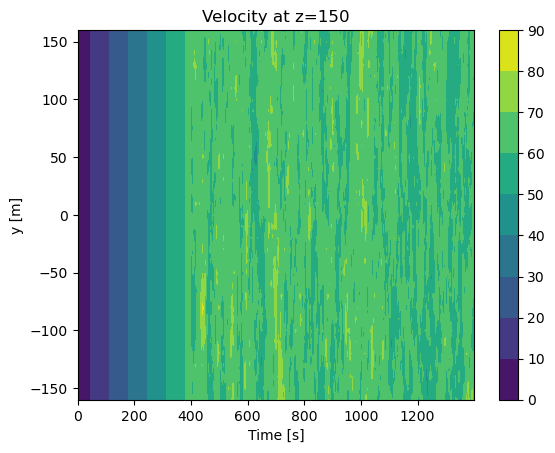

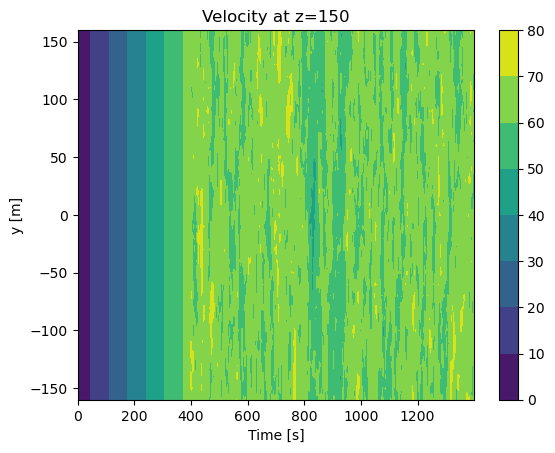

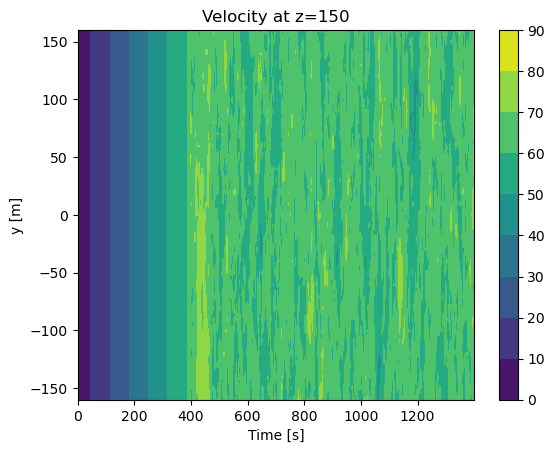

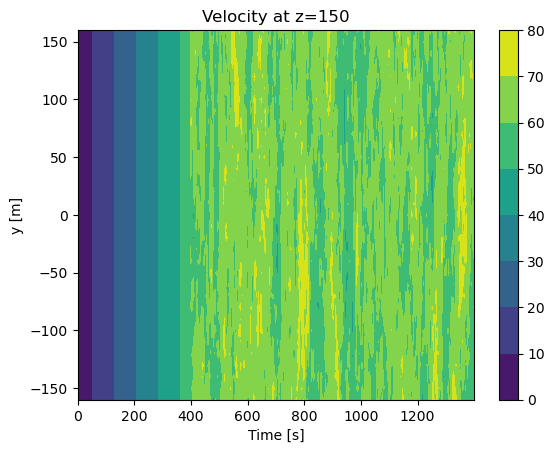

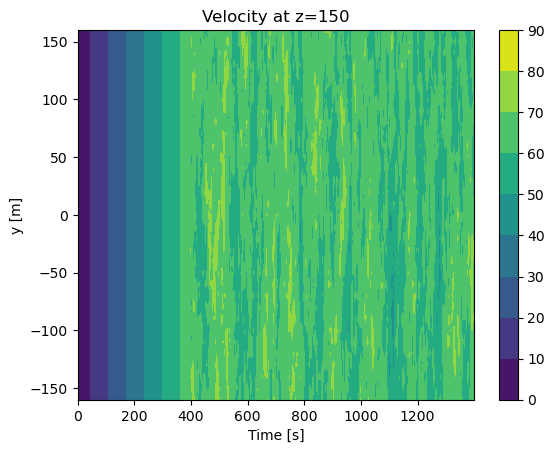

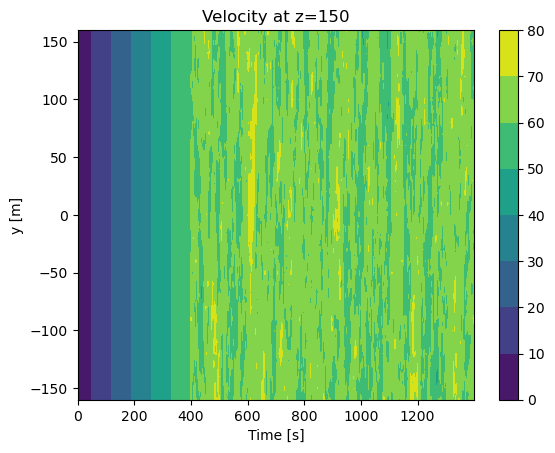

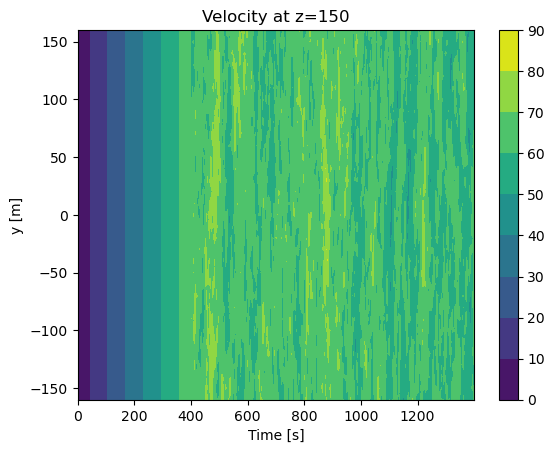

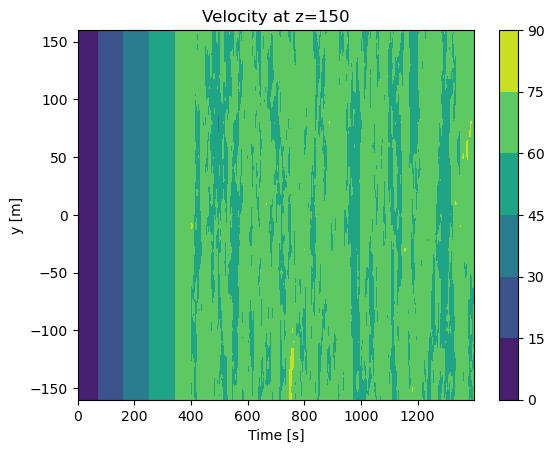

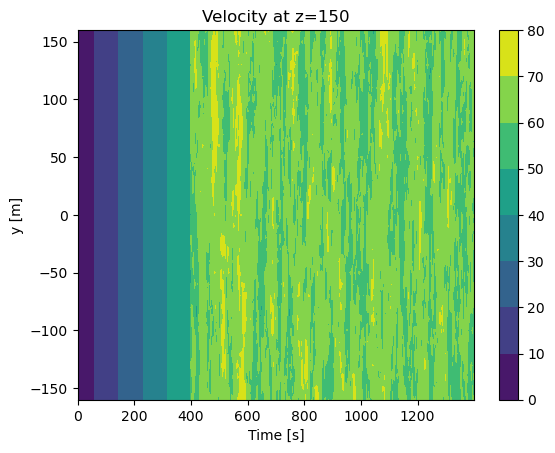

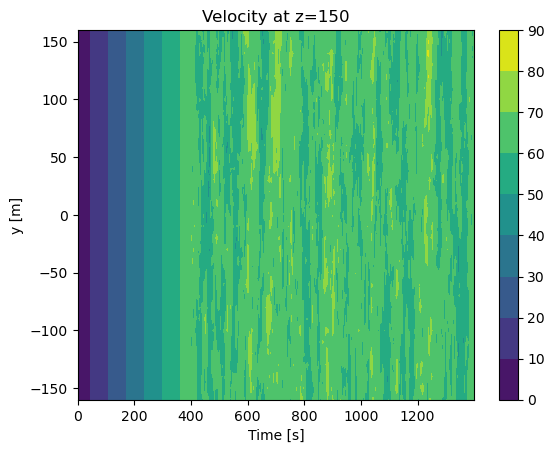

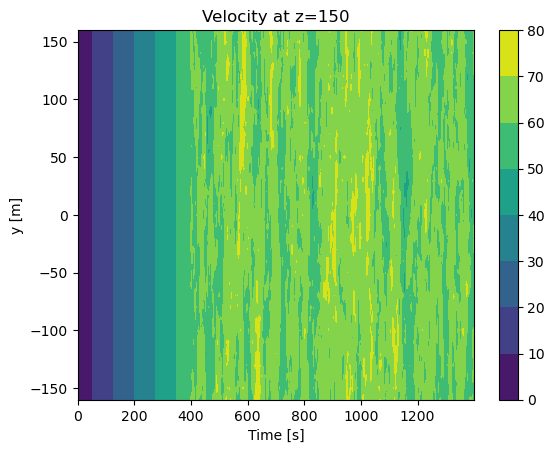

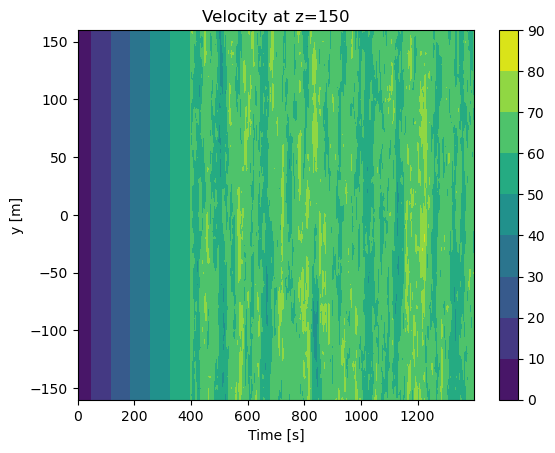

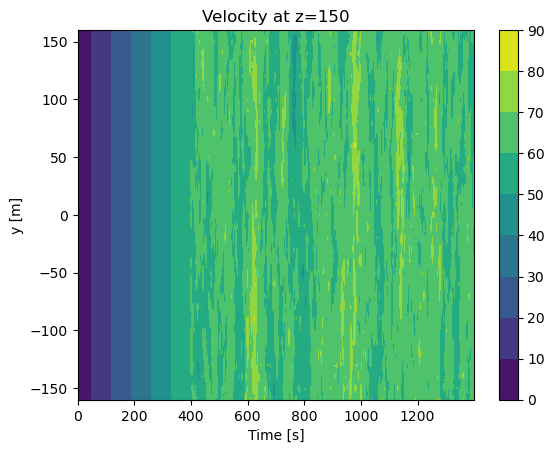

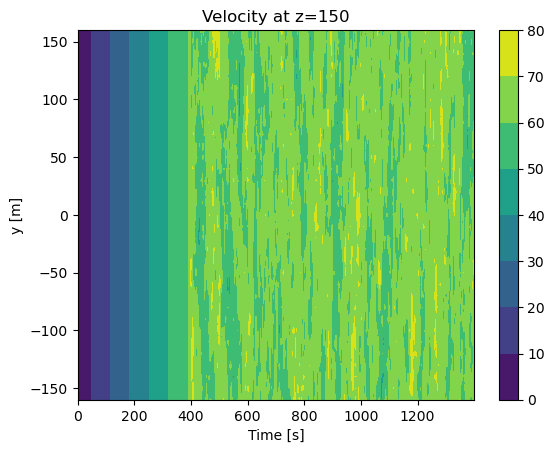

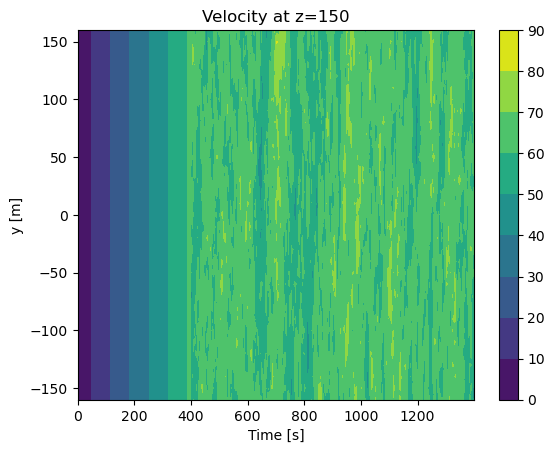

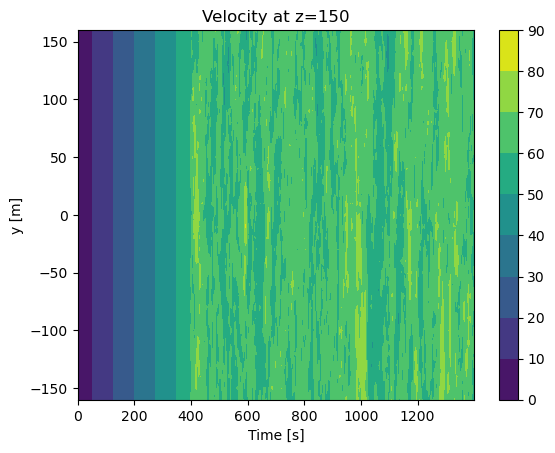

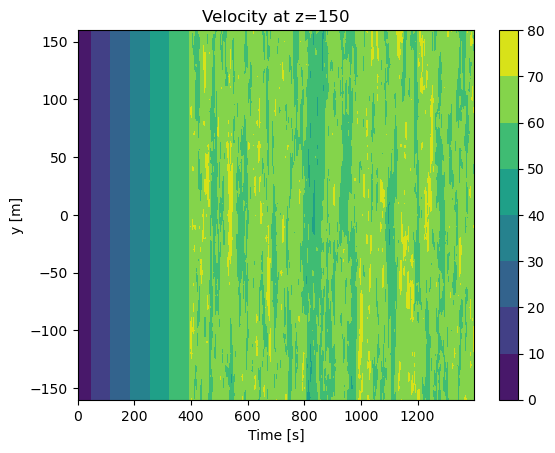

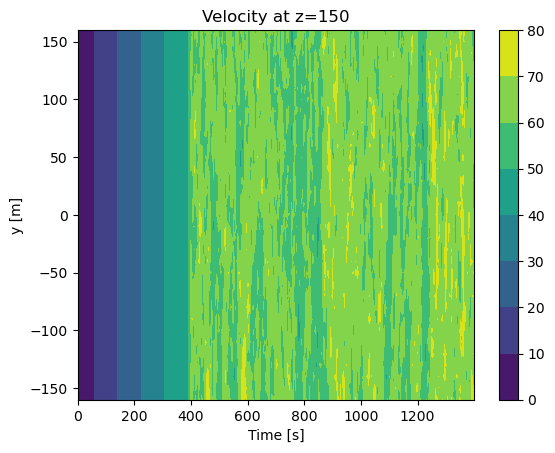

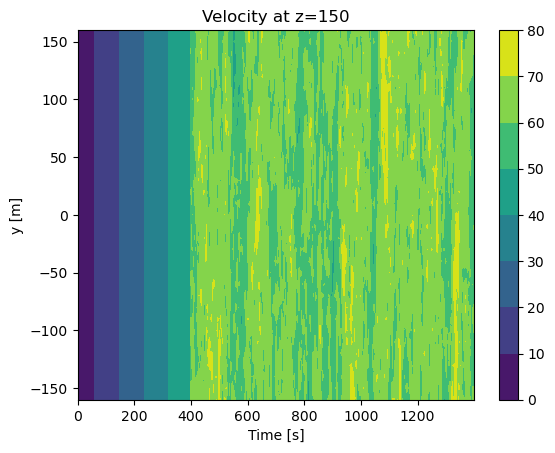

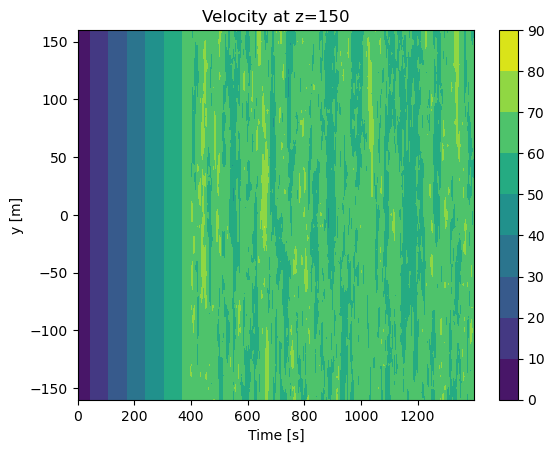

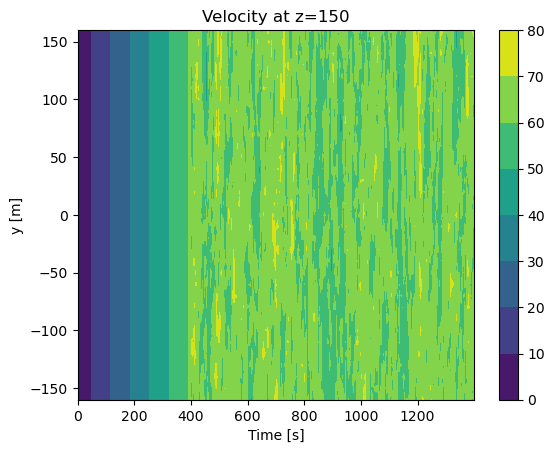

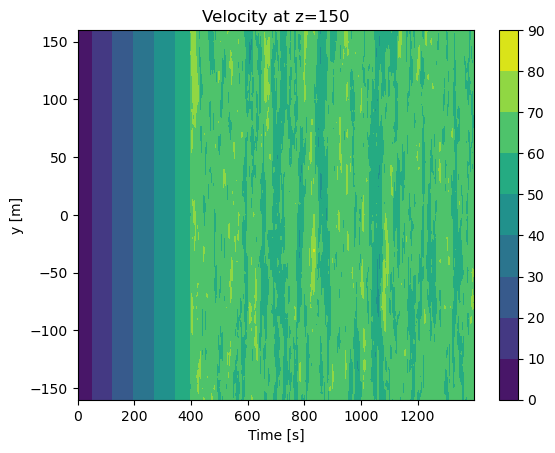

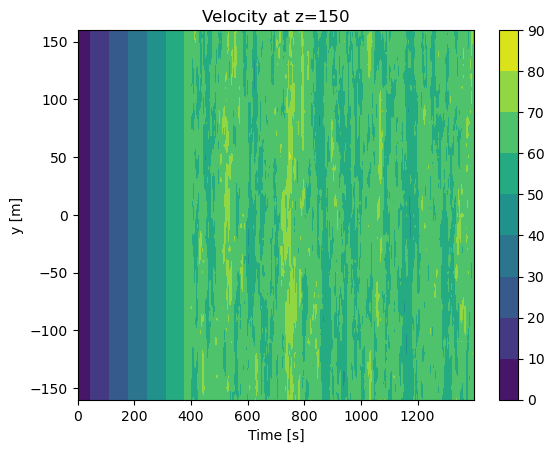

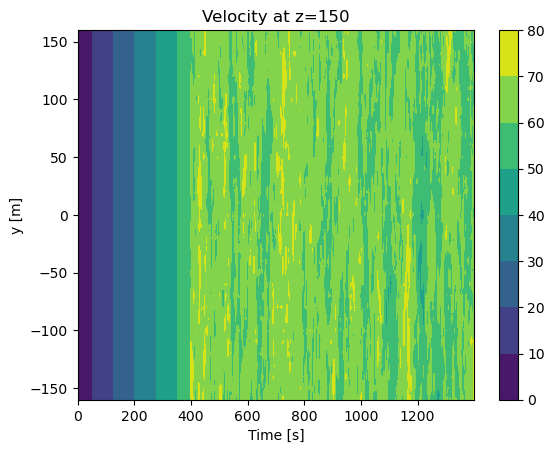

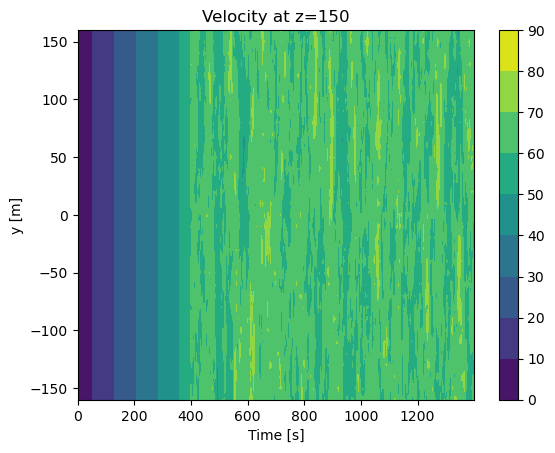

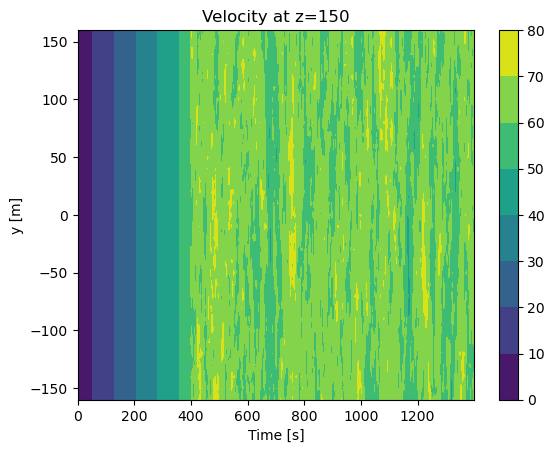

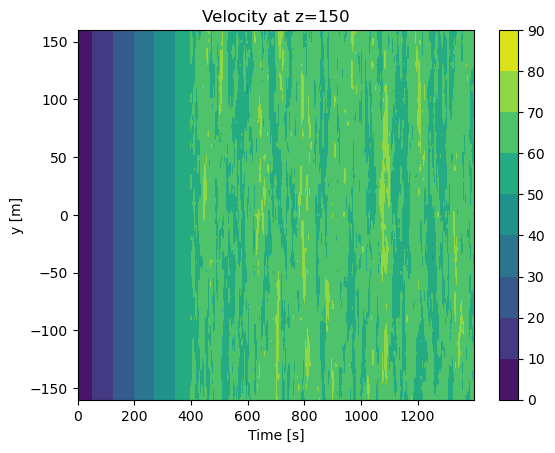

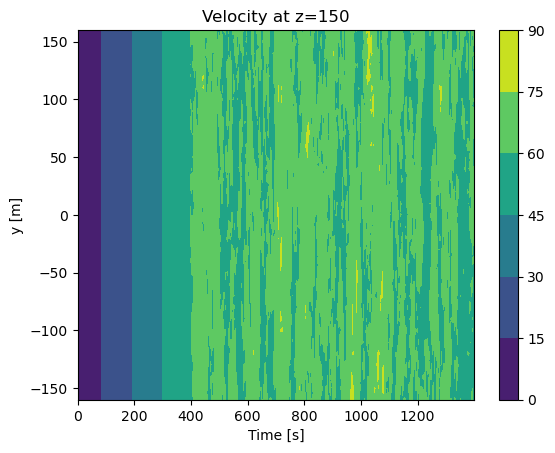

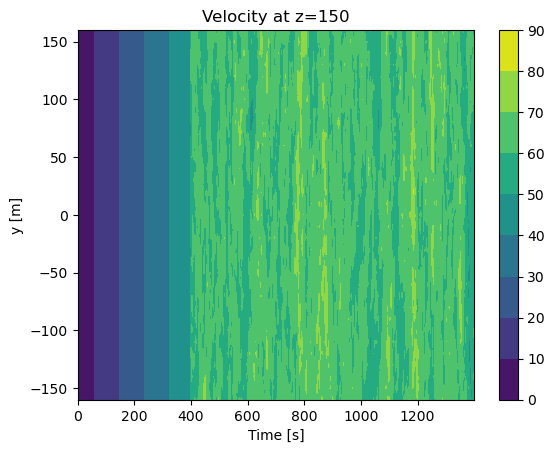

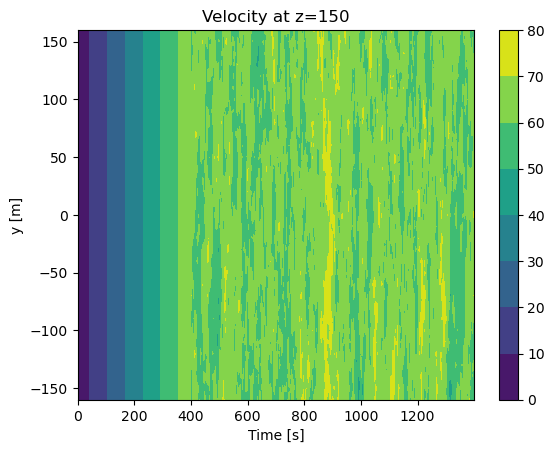

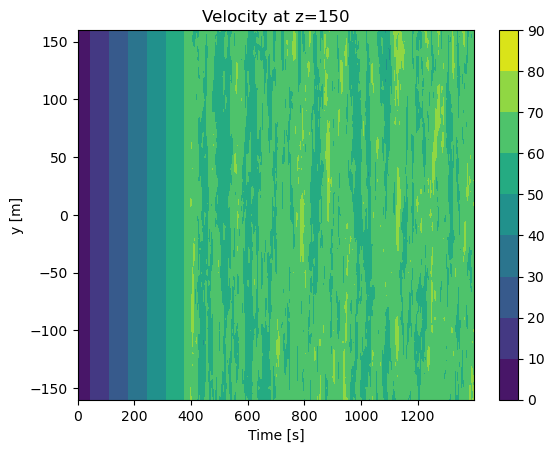

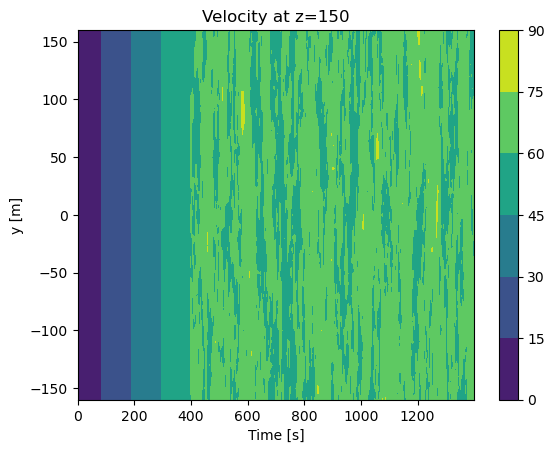

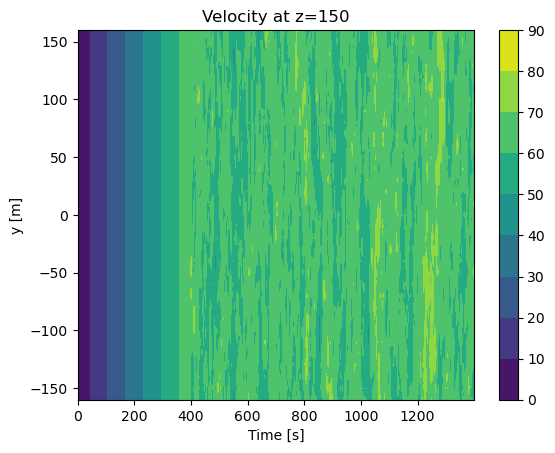

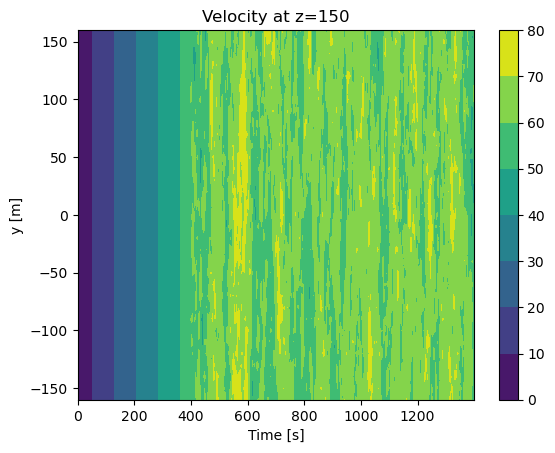

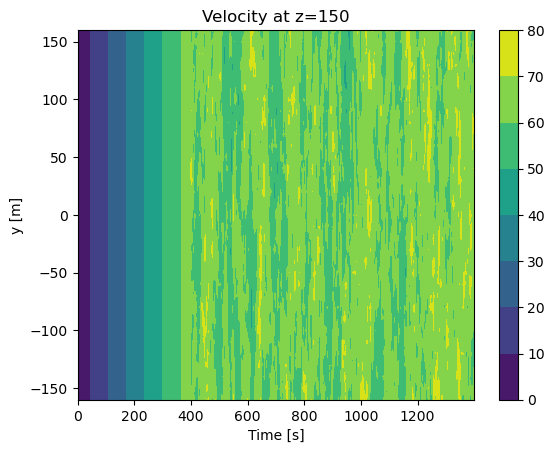

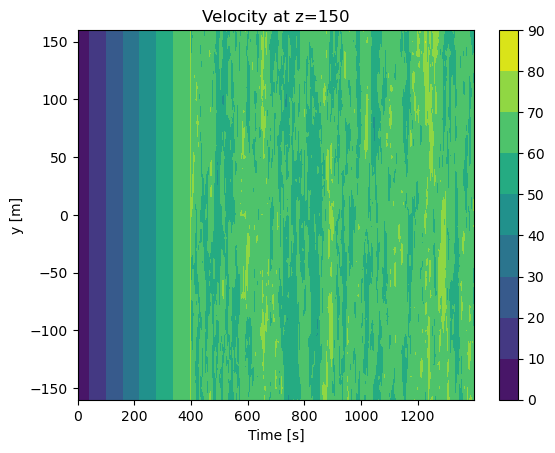

In [5]:
for id, btsFile in enumerate(btsFiles):

    tsMod2 = TurbSimFile(btsFile)
    print(tsMod2)

    time4Ramp = 400.0 # seconds
    dt = tsMod2['dt']
    nRamp = int(time4Ramp / dt)

    iy, iz = tsMod2.closestPoint(y=0, z=150)

    print(nRamp)

    # Compute the ramp required to get to the desired wind speed
    ramp = np.linspace(3.0, tsMod2['u'][0,0,iy,iz], nRamp)


    # Create a new wind field with the ramp
    tempWind = np.zeros(shape=(3, nRamp, tsMod2['y'].size, tsMod2['z'].size), dtype=float)


    for idx in range(ramp.size):
        tempWind[0,idx,:,:] = ramp[idx]
        tempWind[1,idx,:,:] = 0.0
        tempWind[2,idx,:,:] = 0.0

    tsMod2['t'] = np.concatenate((np.linspace(0.0, time4Ramp, nRamp), tsMod2['t'] + time4Ramp), axis=0)
    tsMod2['u'] = np.concatenate((tempWind, tsMod2['u']), axis=1)

    # reshaping the tower wind field
    tsMod2['uTwr'] = tsMod2['uTwr'].reshape(3,tsMod2['t'].size,0)

    # print(tsMod2)

    tsMod2['ID'] = 7 # Changing to non periodic

    # assuming we are reading from the "withoutRamp" folder
    tsMod2.write(f'{os.path.join(os.path.dirname(os.path.dirname(btsFile)), os.path.basename(btsFile)[:-4] + "_ramp.bts")}')

    # --- Extract a horizontal plane and plot it
    U, V, W = tsMod2.horizontalPlane(z=150)
    T, Y = np.meshgrid(tsMod2.t, tsMod2.y)
    fig,ax = plt.subplots(1, 1)
    cs = ax.contourf(T, Y, U.T)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('y [m]')
    ax.set_title('Velocity at z=150')
    plt.colorbar(cs)

    plt.savefig(f'{os.path.join(os.path.dirname(os.path.dirname(btsFile)), os.path.basename(btsFile)[:-4] + "_ramp.png")}')